In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [73]:
data_path = '../../data/postprocessed/PM/'

mapping_table = {
    'NN50PercLeNet5': 'LeNet5',
    'NN50Percmnasnet05': 'MnasNet',
    'NN50Percmobilenetv2': 'MobileNetV2',
    'NN50Percresnet18': 'ResNet18',
    'gpuburn5min': 'GPU-burn'
}

data_sheet = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (('NN50Perc' in file or '5min' in file) and not 'telemetry' in file)]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    df['progress'] = (df['session_id'] - df['session_id'].min()) / (df['session_id'].max() - df['session_id'].min()) * 100
    # print(df[df.isna()])
    data_sheet=pd.concat([data_sheet, df], ignore_index=True)

../../data/postprocessed/PM/NN50PercLeNet5_1.csv
../../data/postprocessed/PM/gpuburn5min_1.csv
../../data/postprocessed/PM/NN50Percresnet18_1.csv
../../data/postprocessed/PM/NN50Percmnasnet05_1.csv
../../data/postprocessed/PM/NN50Percmobilenetv2_1.csv


## Fixing the set of computed metrics across all the experiments

### I want to check if the number of Kernel Injection (Range) affects the number of run sessions.

In [74]:
for label in sorted(data_sheet['Range'].unique()):
    print("--------------------------------------------------------------------")
    print(f'Number of times a kernel is executed for metric computation: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['Range']==label])}")

--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 1
Instances: 27526


### Apparently not

### Thus, it must be dependent only on the application complexity

In [75]:
for label in mapping_table.values():
    print("--------------------------------------------------------------------")
    print(f'App name: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['App_name']==label])}")

--------------------------------------------------------------------
App name: LeNet5
Instances: 264
--------------------------------------------------------------------
App name: MnasNet
Instances: 1968
--------------------------------------------------------------------
App name: MobileNetV2
Instances: 9900
--------------------------------------------------------------------
App name: ResNet18
Instances: 3384
--------------------------------------------------------------------
App name: GPU-burn
Instances: 12010


### Considerations
1. Complexity does not imply stress
2. I think that the complexity is due also to the number of kernels that the application comprises

TODO: look at Future works

### Available data

In [76]:
location_mapping={
    'gpc': 'GPU Processing Cluster',
    'gr': 'Graphics Engine',
    'sm': 'Streaming Multiprocessor',
    'dramc': 'Dynamic RAM Controller',
    'pcie': 'PCI Express',
    'tpc': 'Texture Processing Cluster'
}
data_sheet['location'].unique()

array(['gpc', 'gr', 'tpc', 'sm', 'dramc', 'pcie'], dtype=object)

In [77]:
data_sheet['HR_location'] = data_sheet['location'].map(location_mapping)
# data_sheet.drop('location', axis=1, inplace=True)

In [78]:
data_sheet['location'].unique()

array(['gpc', 'gr', 'tpc', 'sm', 'dramc', 'pcie'], dtype=object)

In [79]:
len(data_sheet)
239172-19931

219241

In [80]:
metric_event_mapping= {
    'cycles_elapsed': 'Total elapsed cycles [Cycles/s]',
    'cycles_active': 'Active cycles [Cycles/s]',
    'warps_active_realtime': 'Active warps [%]',
    'inst_executed': 'Executed instructions [%]',
    'ipe_tensor_cycles_active':'Tensor Cores Active Cycles [%]',
    'sectors_op_read':'Read Sectors [%]',
    'sectors_op_wtite':'Written Sectors [%]',
    'read_bytes':'Read bytes (CPU to GPU) [%]',
    'write_bytes':'Written bytes (GPU to CPU) [%]',
}
data_sheet['metric_name'].unique()

# pcie metrics are computed in a different way and it is better to keep them as a percentace
data_sheet = data_sheet[~((data_sheet['rollup_operation'] == 'sum') & (data_sheet['metric_name'] == 'read_bytes'))]

In [81]:

# It is a useless column, we can drop it
data_sheet = data_sheet.drop('rollup_operation', axis=1)

In [82]:
data_sheet['HR_metric_name'] = data_sheet['metric_name'].map(metric_event_mapping)
# data_sheet.drop('metric_name', axis=1, inplace=True)

In [83]:
data_sheet['metric_name'].unique()

array(['cycles_elapsed', 'cycles_active', 'warps_active_realtime',
       'inst_executed', 'pipe_tensor_cycles_active', 'sectors_op_read',
       'sectors_op_write', 'read_bytes', 'write_bytes'], dtype=object)

### Let's fix for a second the Number of times a kernel is executed for metric computations to 1

In [84]:
data_sheet['Range'].dtypes

dtype('int64')

In [85]:
data_sheet_1 = data_sheet[data_sheet['Range']==1]

In [86]:
data_sheet['HR_metric_name'].unique()

array(['Total elapsed cycles [Cycles/s]', 'Active cycles [Cycles/s]',
       'Active warps [%]', 'Executed instructions [%]', nan,
       'Read Sectors [%]', 'Read bytes (CPU to GPU) [%]',
       'Written bytes (GPU to CPU) [%]'], dtype=object)

### Regardless of the application I want to see the correlation within the columns

In [87]:
df_l2_1 = data_sheet_1[data_sheet_1['HR_location']=='GPU Processing Cluster']
df_sm_1 = data_sheet_1[data_sheet_1['HR_location']=='Graphics Engine']
df_smsp_1 = data_sheet_1[data_sheet_1['HR_location']=='Streaming Multiprocessor']
df_sys_1 = data_sheet_1[data_sheet_1['HR_location']=='PCI Express']
df_dram_1 = data_sheet_1[data_sheet_1['HR_location']=='Dynamic RAM Controller']

dfs = {
    'GPU Processing Cluster': df_l2_1, 
    'Graphics Engine': df_sm_1, 
    'Streaming Multiprocessor': df_smsp_1, 
    'PCI Express': df_sys_1, 
    'Dynamic RAM Controller': df_dram_1
    }

In [88]:
df_pivot_l2_1 = df_l2_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm_1 = df_sm_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp_1 = df_smsp_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sys_1 = df_sys_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_dram_1 = df_dram_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'GPU Processing Cluster': df_pivot_l2_1, 
    'Graphics Engine': df_pivot_sm_1, 
    'Streaming Multiprocessor': df_pivot_smsp_1, 
    'PCI Express': df_pivot_sys_1, 
    'Dynamic RAM Controller': df_pivot_dram_1
    }

In [89]:
metric_full_name = data_sheet_1['HR_location'] +' '+ data_sheet_1['HR_metric_name']
metric_full_name

0        GPU Processing Cluster Total elapsed cycles [C...
1                 Graphics Engine Active cycles [Cycles/s]
2              Texture Processing Cluster Active warps [%]
3        Streaming Multiprocessor Active cycles [Cycles/s]
4        Streaming Multiprocessor Executed instructions...
                               ...                        
27520              Dynamic RAM Controller Read Sectors [%]
27521                                                  NaN
27522              PCI Express Read bytes (CPU to GPU) [%]
27523           PCI Express Written bytes (GPU to CPU) [%]
27525           PCI Express Written bytes (GPU to CPU) [%]
Length: 25232, dtype: object

/home/bepi/anaconda3/envs/gpustress/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/bepi/anaconda3/envs/gpustress/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


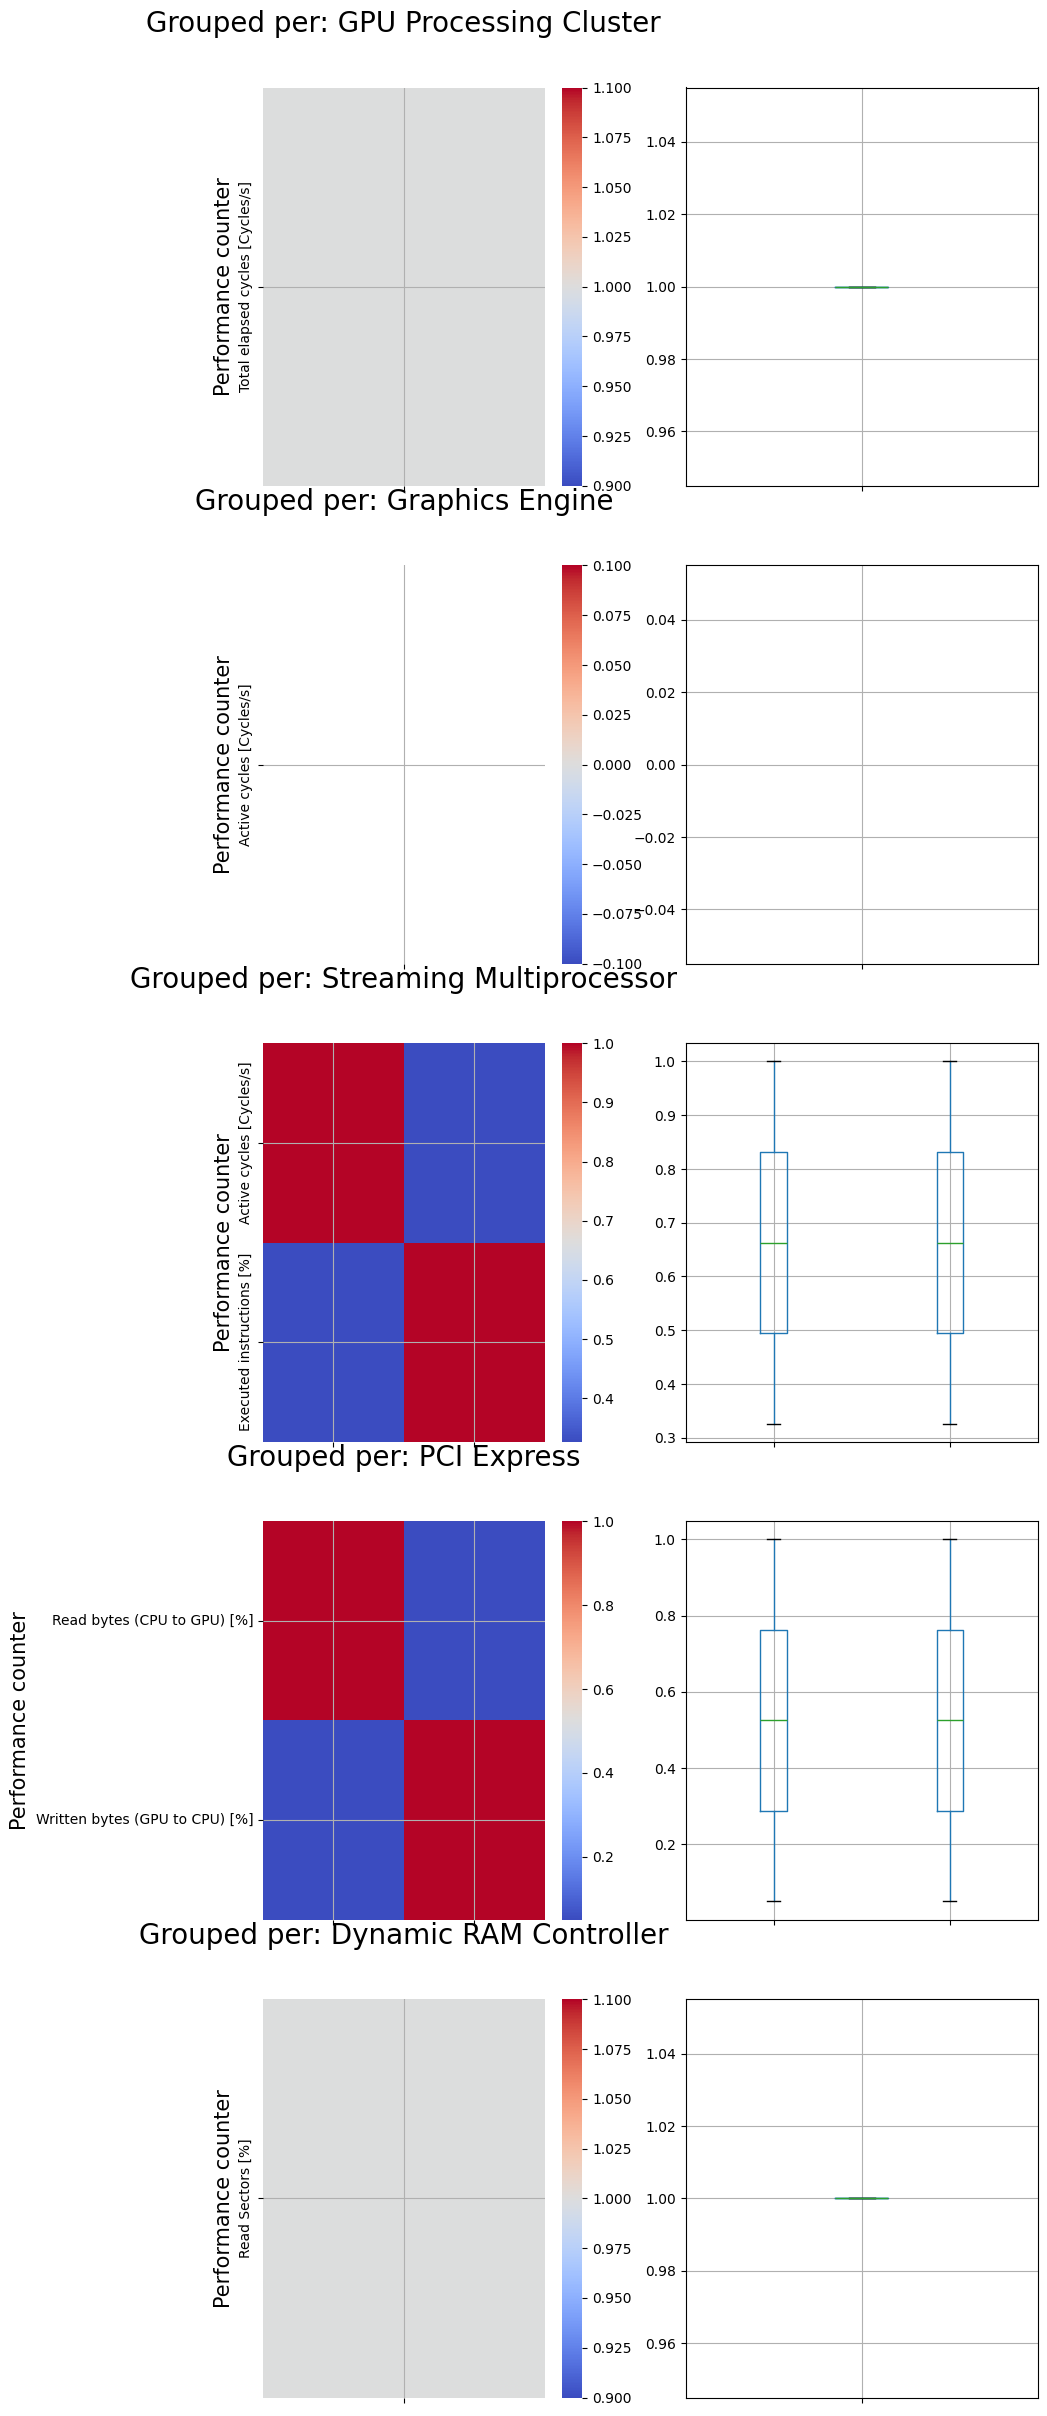

In [90]:
fig, ax = plt.subplots(5,2,figsize=(10,30))
for pivot_df_idx in range(len(list(pivot_dfs.values()))):
    HR_location = list(pivot_dfs.keys())[pivot_df_idx]
    # print(pivot_dfs[HR_location].select_dtypes(include=['float64']))
    # data_to_corr = pivot_dfs[HR_location][cols_to_corr]
    # target_data = data_to_corr.drop('HR_location', axis = 1)
    data_to_corr = pivot_dfs[HR_location].select_dtypes(include=['float64'])
    matrix = data_to_corr.corr()
    matrix.boxplot(ax=ax[pivot_df_idx][1])
    sns.heatmap(matrix, annot=False, cmap='coolwarm', ax=ax[pivot_df_idx][0])
    ax[pivot_df_idx][0].set_title(f"Grouped per: {HR_location}", fontsize=20, pad=40)
    ax[pivot_df_idx][0].grid()
    ax[pivot_df_idx][0].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][0].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][1].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].set_xticklabels([])
    ax[pivot_df_idx][1].set_xticklabels([])
    ax[pivot_df_idx][0].set_xlabel('')

### Stress evaluation

In [94]:
# hue_order = ['Backpropagation algorithm', 'Gaussian Elimination', 'Lenet5', 'GPU-burn']

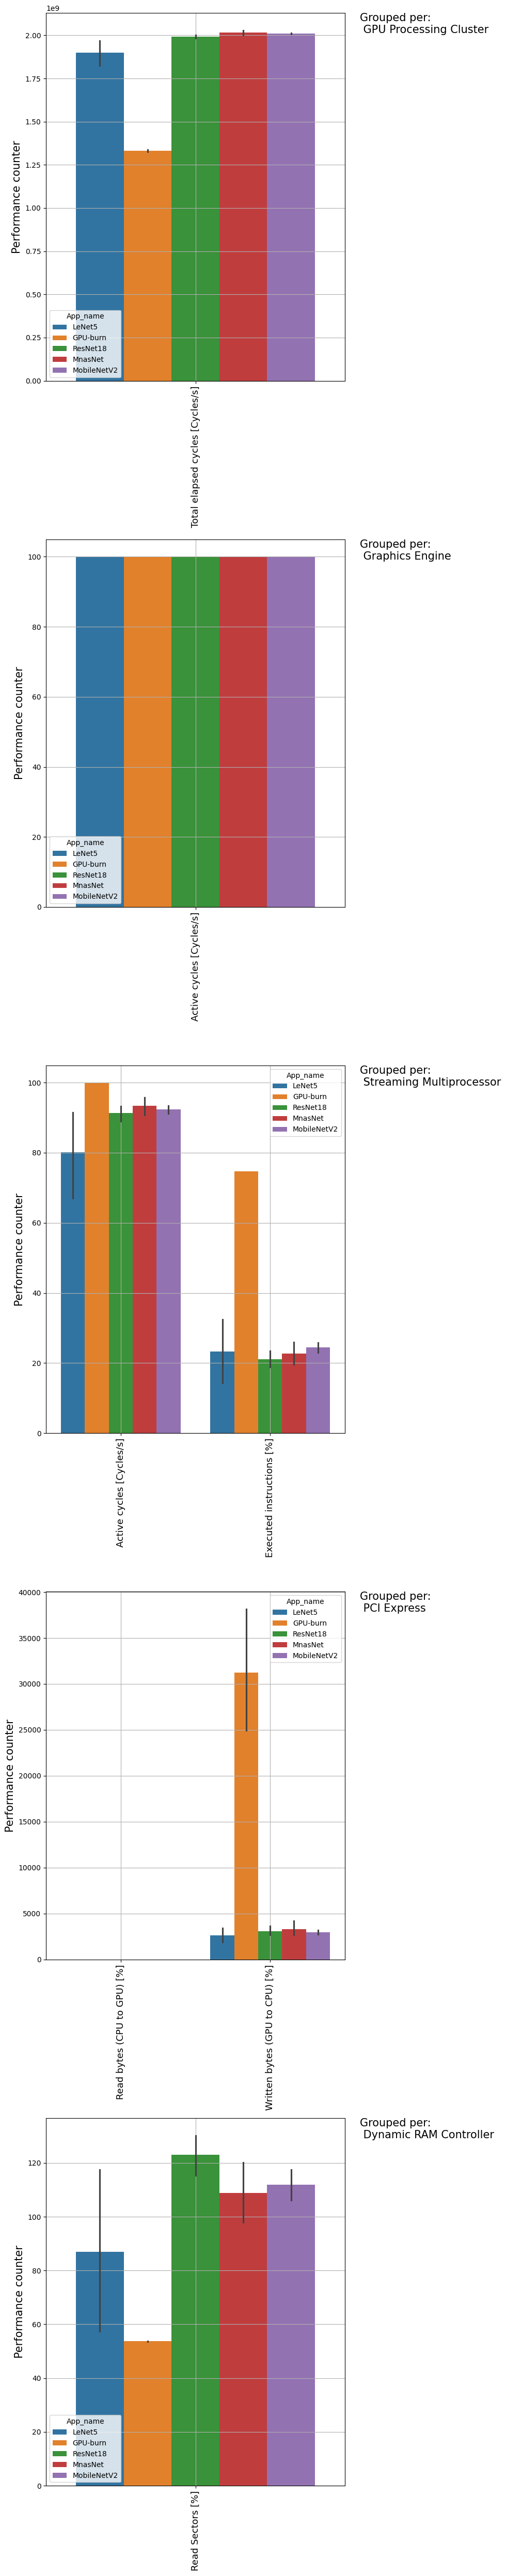

In [95]:
fig, ax = plt.subplots(5,1,figsize=(10,50))
for pivot_df_idx in range(len(list(dfs.values()))):
    HR_location = list(dfs.keys())[pivot_df_idx]
    # data_to_corr = dfs[HR_location].select_dtypes(include=['float64'])
    sns.barplot(data = dfs[HR_location], x='HR_metric_name', y='metric_value', hue='App_name', ax = ax[pivot_df_idx])
    # ax[pivot_df_idx].set_title(f"Grouped per: {HR_location}", fontsize=20, loc='right')
    ax[pivot_df_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[pivot_df_idx].transAxes,
         ha='left', va='top', fontsize=15)
    ax[pivot_df_idx].grid()
    # ax[pivot_df_idx].set_yscale('log')
    ax[pivot_df_idx].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[pivot_df_idx].set_xticklabels([])
    ax[pivot_df_idx].set_xlabel('')
plt.tight_layout()

/tmp/ipykernel_10801/3451042502.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_10801/3451042502.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_10801/3451042502.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_10801/3451042502.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykern

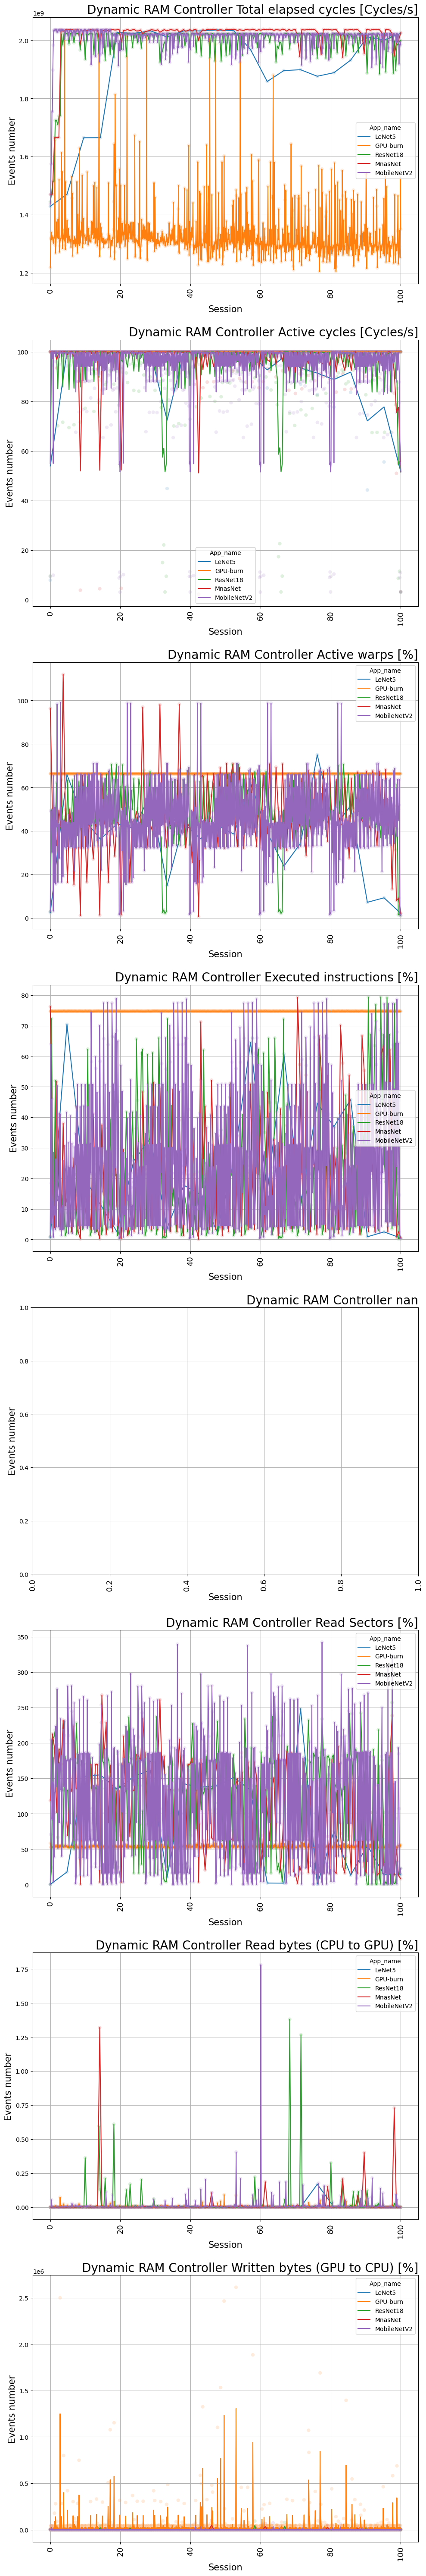

In [96]:
fig, ax = plt.subplots(8,1,figsize=(10,60))
for metric_idx in range(len(data_sheet_1['HR_metric_name'].unique())):
    metric_name = data_sheet_1['HR_metric_name'].unique()[metric_idx]
    data = data_sheet_1[data_sheet_1['HR_metric_name'] == metric_name]
    # HR_location=data['HR_location'].unique()[0]
    sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
    sns.scatterplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], alpha=0.15, legend=False)
    ax[metric_idx].set_title(f"{HR_location} {metric_name}", fontsize=20, loc='right')
    # ax[metric_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[metric_idx].transAxes,
    #      ha='left', va='top', fontsize=15)
    ax[metric_idx].grid()
    # ax[metric_idx].set_yscale('log')
    ax[metric_idx].set_xlabel('Session', fontsize=15)
    ax[metric_idx].set_ylabel('Events number', fontsize=15)
    ax[metric_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[df_idx].set_xticklabels([])
plt.tight_layout()

Text(0.5, 0, '')

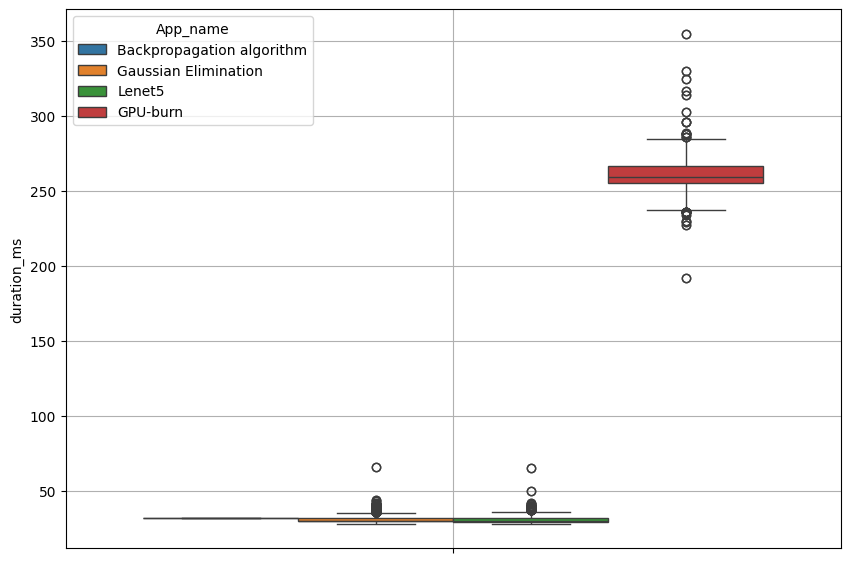

In [71]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
HR_location=data['HR_location'].unique()[0]
sns.boxplot(data, y='duration_ms', hue='App_name', ax = ax, hue_order=hue_order)
ax.grid()
ax.set_xlabel('', fontsize=15)

Text(0.5, 0, '')

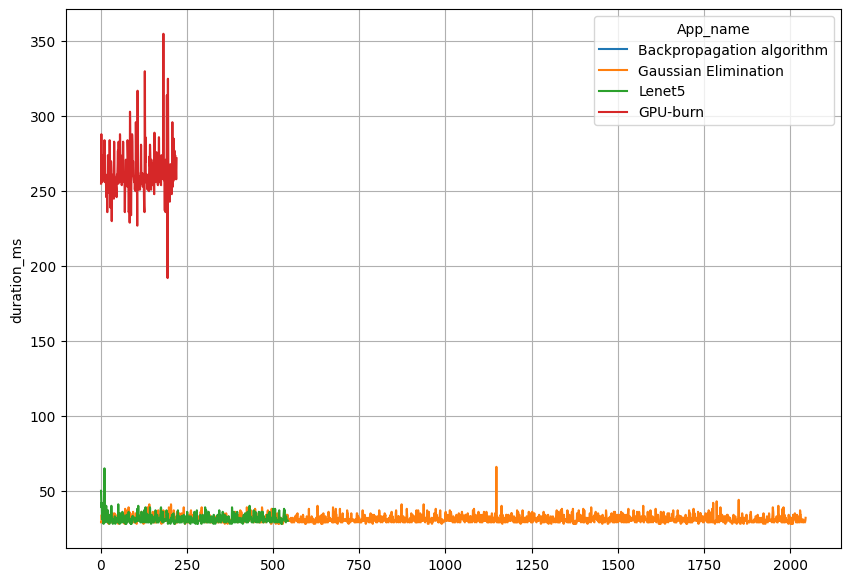

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
HR_location=data['HR_location'].unique()[0]
sns.lineplot(data, x='session_id' ,y='duration_ms', hue='App_name', ax = ax, hue_order=hue_order)
ax.grid()
ax.set_xlabel('', fontsize=15)

### Final remarks

### Future works
1. Use the correlation ID to correlate instructions with SASS code 
2. Explore the possibility to use sass_source_map or sass_metrics
3. 